In [1]:
#import modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.stats import zscore
import sklearn
from sklearn.model_selection import train_test_split
import fnmatch

In [2]:
#functions for finding and reading data files

def find_files(directory, pattern='Data*.csv', withlabel=True):
    '''fine all the files in one directory and assign '1'/'0' to F or N files'''
    files = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            if withlabel:
                if 'non-seizure' in filename:
                    label = '0'
                else:
                    label = '1'
                files.append((os.path.join(root, filename), label))
            else:  # only get names
                files.append(os.path.join(root, filename))
    
    return files

def read_data(filename, header=None, ifnorm=False):
    '''read data from .csv
    Param:
        filename: string e.g. 'data/Data_F_Ind0001.csv'
        ifnorm: boolean, 1 zscore normalization
        start: with filter augmented data, start index of the column indicate which group of data to use
        width: how many columns of data to use, times of 2
    return:
        data: 2d array [seq_len, channel]'''

    data = pd.read_csv(filename, header=header, nrows=None)
    data = data.values  ### get data without row_index
    if ifnorm:   ### 2 * 10240  normalize the data into [0.0, 1.0]]
        data_norm = zscore(data)
        data = data_norm
    #data = np.squeeze(data)   ## shape from [1, seq_len] --> [seq_len,]
    return data


In [3]:
#find segmented files and return them with label
seg_files_wlabel = find_files('C:\\Users\\hien\\Desktop\\eeg_data\\seg_data', pattern='seg*.csv', withlabel=True)

print("first file with label:", seg_files_wlabel[0])

first file with label: ('C:\\Users\\hien\\Desktop\\eeg_data\\seg_data\\segNorm_read_out_annosep09_anno_115_non-seizure_No0.csv', '0')


In [4]:
#split files and labels

files, labels = np.array(seg_files_wlabel)[:, 0].astype(np.str), np.array(np.array(seg_files_wlabel)[:, 1]).astype(np.int)

#print("first filename:", files[0])
#print("list of all labels", labels)

In [5]:
#length of a signal
#len(signals[0])

In [6]:
#number of elements in files/labels
len(labels)

540

In [333]:
#split data into training and testing

files_train, files_test, labels_train, labels_test = train_test_split(files, labels, test_size=0.4, random_state=42)

#print(labels_train)
print("number of test input:", len(labels_test))
print("number of training input:", len(labels_train))


number of test input: 216
number of training input: 324


In [334]:
#set parameters

learning_rate = 0.001
total_epochs = 30 #number of iterations over all samples / epoch
batch_size = 64 #amount of files fed to model per iteration
test_sample = len(labels_test)
total_batches = len(labels_train)//batch_size
num_classes = 2


In [335]:
#set variables x=input, y_=output, W=weights, b=bias

# Placeholder variable for the input images
x = tf.placeholder("float",[None, 2048, 1], name = "x") #number of data points
# Reshape it into [num_images, img_height, img_width, num_channels]
x_image = tf.reshape(x, [-1, 2048, 1, 1]) #why reshape?

# Placeholder variable for the true labels associated with the images
y_true = tf.placeholder("float",[None,2], name = "y_true") #2 possible outputs
y_true_cls = tf.argmax(y_true, axis=1) 


In [336]:
#set var

filter_no_1 = 4
filter_no_2 = 4
filter_no_3 = 4
filter_no_4 = 4
filter_no_5 = 4

filtersize_1 = 9
filtersize_2 = 9
filtersize_3 = 9
filtersize_4 = 9
filtersize_5 = 9

poolsize_1 = 4
poolsize_2 = 4
poolsize_3 = 4
poolsize_4 = 4
poolsize_5 = 4

stride_1 = 1
stride_2 = 1
stride_3 = 1
stride_4 = 1
stride_5 = 1

poolstride_1 = 2
poolstride_2 = 2
poolstride_3 = 2
poolstride_4 = 2
poolstride_5 = 2


dense_neu_1 = 100
dense_neu_2 = 30

In [337]:
#set up network


layer = tf.layers.conv2d(x_image, filter_no_1, [filtersize_1, 1], strides = (stride_1, 1), padding = "same", activation = tf.nn.relu)

layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[poolsize_1, 1], strides= [poolstride_1, 1])

#layer = tf.layers.conv2d(layer, filter_no_2, [filtersize_2, 1], strides = (stride_2, 1), padding = "same", activation = tf.nn.relu)

#layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[poolsize_2, 1], strides= [poolstride_2, 1])

#layer = tf.layers.conv2d(layer, filter_no_3, [filtersize_3, 1], strides = (stride_3, 1), padding = "same", activation = tf.nn.relu)

#layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[poolsize_3, 1], strides= [poolstride_3, 1])#poolsize/strides: 2, 4, 6... filter size

#layer = tf.layers.conv2d(layer, filter_no_4, [filtersize_4, 1], strides = (stride_4, 1), padding = "same", activation = tf.nn.relu)

#layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[poolsize_4, 1], strides= [poolstride_4, 1])

#layer = tf.layers.conv2d(layer, filter_no_5, [filtersize_5, 1], strides = (stride_5, 1), padding = "same", activation = tf.nn.relu)

#layer = tf.layers.max_pooling2d(inputs=layer, pool_size=[poolsize_5, 1], strides= [poolstride_5, 1])

flatten_layer = tf.layers.flatten(layer, name=None)

layer = tf.layers.dense(flatten_layer, 100, activation=tf.nn.relu)

layer = tf.nn.dropout(layer, keep_prob = 0.3, noise_shape=None, seed=None, name=None)

output = tf.layers.dense(layer, 2, activation=tf.nn.softmax)



In [338]:
network_output = tf.argmax(output, axis=1) 

In [339]:
#define and minimze cost function

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y_true)
loss_op = tf.reduce_mean(cross_entropy)

In [340]:
#training

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_op) 

In [341]:
#Determining accuracy of parameters

correct_prediction = tf.equal(tf.argmax(output, axis=1), y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [342]:
#rearrange dataset

dataset_train = tf.data.Dataset.from_tensor_slices((files_train, labels_train)).repeat().batch(batch_size).shuffle(buffer_size=10000)
iter = dataset_train.make_initializable_iterator()
ele = iter.get_next()   #you get the filename

acc train 0.603125
acc train 0.978125
acc train 0.99375
acc test [0.75462961 0.81481481 0.875      0.88425928 0.89814812 0.93518519
 0.93518519 0.92592591 0.94907409 0.93518519 0.94444442 0.94907409
 0.95833331 0.92592591 0.92592591 0.94444442 0.9537037  0.94907409
 0.93055558 0.96296299 0.94444442 0.94444442 0.94907409 0.92592591
 0.94444442 0.93981481 0.9537037  0.95833331 0.94444442 0.94907409]


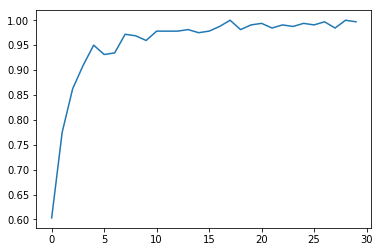

In [343]:
#run session and plot train accuracy

with tf.Session() as sess:
    sess.run(iter.initializer)
    sess.run(tf.global_variables_initializer())
    
    acc_epoch = np.zeros((total_epochs)) 
    acc_epoch_test = np.zeros((total_epochs)) 
    
    for epoch in range(total_epochs):
        acc_batch = 0
        acc_batch_test = 0
        avg_cost = 0
    
        for batch in range(total_batches):
            files_train, labels_train =  sess.run(ele)   # names, 1s/0s the filename is bytes object!!! TODO
            
            data_train = np.zeros([batch_size, 2048, 1])
            files_train = files_train.astype(np.str)
            
            for ind in range(batch_size):
                
                data = read_data(files_train[ind],  header=None, ifnorm=True)
                data_train[ind, :] = data
            
            labels_train_hot =  np.eye((num_classes))[labels_train.astype(int)] # get one-hot lable
            
            acc, _, pred, loss = sess.run([accuracy, optimizer, correct_prediction, loss_op], feed_dict={x: data_train, y_true: labels_train_hot})
        
        
            acc_batch += acc 
    
        acc_epoch[epoch] = acc_batch / total_batches
        avg_cost += loss / total_batches
        if epoch % 10 == 0:
            print("acc train", acc_batch / total_batches)
        
        data_test = np.zeros([test_sample, 2048, 1])
        for test_nr in range(test_sample):
            
            files_test = files_test.astype(np.str)
                
            data_test_01 = read_data(files_test[test_nr],  header=None, ifnorm=True)
            data_test[test_nr, :] = data_test_01
            
        labels_test_hot = np.eye((num_classes))[labels_test.astype(int)]
        
        acc_test, pred_test, pred_labels = sess.run([accuracy, correct_prediction, network_output], feed_dict={x: data_test, y_true: labels_test_hot})
        
        #acc_batch_test += acc_test 
    
        acc_epoch_test[epoch] = acc_test 
    print("acc test", acc_epoch_test)
        
        
        
            

            
plt.plot(np.array(acc_epoch))   


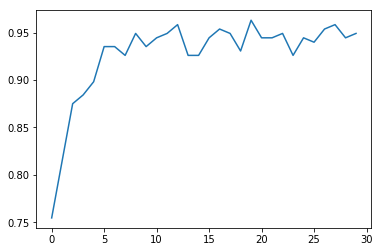

In [344]:
plt.plot(np.array(acc_epoch_test))  

In [345]:
avg_cost

0.06380176544189453

In [346]:
#pred_test

In [347]:
#pred

In [348]:
sklearn.metrics.confusion_matrix(labels_test, pred_labels, labels=None, sample_weight=None)

array([[109,   6],
       [  5,  96]], dtype=int64)